In [1]:
main_directory="/Users/samuelcourville/Documents/JPL/combinedModel/"

# required stuff
import sys
sys.path.insert(1, main_directory+'thermal')
sys.path.insert(1, main_directory+'aqueous')
sys.path.insert(1, main_directory+'transport')
sys.path.insert(1, main_directory+'rock')
sys.path.insert(1, main_directory+'tables')
sys.path.insert(1, main_directory+'plotting')
import matplotlib.pyplot as plt
import numpy as np

# 1). Import WOW!

In [2]:
# import WOW (WOW! Ocean Worlds)
import WOW

# 2). Create model grid

In [3]:
######### define grid ##############

nr = 51       # Number of radii
maxnt = 4000   # Maximum number of time steps

YR = 3.1536E7            #(Year to seconds conversion)
StartTime=2.5*10**6*YR   # Myrs
EndTime = 4567*10**6*YR  # Myrs. Stop time if maxnt is not reached Myr
Radius = 480000          # meters

# parameters for perplex grid
temp_step = 25 # how many degrees temperature difference before recalculating thermal properties? 
press_step= 10 # how many radius points between each perplex equilibration calculation

Ceres = WOW.Planet(nr,StartTime,EndTime,Radius,maxnt,temp_step,press_step)

# 3). Initialize model composition

### 3a starting temperature

In [4]:
# Starting temperature
init_Temp = 180

### 3b starting bulk composition

In [5]:
########### initialize comp ############

# Starting composition (Mass fraction of ice and rock must sum to 1)
ICE_frac=0.02
#OrgFrac=0.20
OrgFrac=0.02 # percentage of rock that is organics

# Ice composition
# Ci
init_IceComp={'H2O':100.0}#,'C':0.272,'O':0.728} #,'CO':0,'NH3':2.0,'CH4':0} #,'NH3':0.1, 'CO2'}
#init_IceComp={'H2O':100.0,'CO2':0.0,'NH3':0.0,'CH4':0.0} #,'CO':0,'NH3':2.0,'CH4':0} #,'NH3':0.1, 'CO2'}
# Comet
#init_IceComp={'H2O':62.5,'CO2':30.0,'NH3':5.0,'CH4':2.5}#,'CO':12.5}#,'NH3':2.0,'CH4':0} #,'NH3':0.1, 'CO2'}

# Rock composition
#init_RockComp={"H":3.333,"C":0.00,"Mg":32.6277,"Al":0.00,"Si":15.5176,"S":0.00,"Ca":0.00,"Fe":5.0295,"O":43.4922,"Na":0.00,"N":0.00}
#init_RockComp={"H":3.93,"C":57.26,"Mg":1.55,"Al":0.28,"Si":16.41,"S":1.20,"Ca":0.13,"Fe":9.49,"O":57.26,"Na":1.09,"N":0.35}

# Comet dust
#init_RockComp={"H":4.50,"C":6.23,"Mg":7.80,"Al":0.72,"Si":11.26,"S":3.22,"Ca":0.74,"Fe":11.93,"O":52.89,"Na":0.43,"N":0.28}

# CI
#init_RockComp={"H":3.674,"C":2.493,"Mg":9.751,"Al":0.902,"Si":8.26,"S":5.360,"Ca":0.924,"Fe":18.668,"O":47.063,"Na":0.538,"N":0.30}
init_RockComp={"H":4.751,"C":2.784,"Mg":7.313,"Al":0.676,"Si":7.746,"S":4.020,"Ca":0.693,"Fe":14.001,"O":57.196,"Na":0.403,"N":0.417}
#init_RockComp={"H":4.799,"C":2.847,"Mg":7.490,"Al":0.693,"Si":7.933,"S":2.305,"Ca":0.710,"Fe":14.339,"O":58.471,"Na":0.413,"N":0.000}








# Reweight rock and ice compositions so they sum to 1
sumR=0
for key in init_RockComp:    
    sumR = sumR+init_RockComp[key]
    init_RockComp[key] *= (1-OrgFrac)/100
    init_RockComp[key] *= (1.0-ICE_frac)
    
sumI=0
for key in init_IceComp:    
    sumI = sumI+init_IceComp[key]
    init_IceComp[key] *= (ICE_frac/100)

# Organic composition
init_orgMass=OrgFrac*(1.0-ICE_frac)
init_orgFrac=OrgFrac

Hwt= 0.65*1
Cwt= 1.0*12.01
Owt= 0.17*16
TotWt=Hwt+Cwt+Owt
Hwt=Hwt/TotWt*OrgFrac
Cwt=Cwt/TotWt*OrgFrac
Owt=Owt/TotWt*OrgFrac

init_orgComp={}
init_orgComp["H"]=Hwt/init_RockComp["H"]
init_orgComp["C"]=Cwt/init_RockComp["C"]
init_orgComp["O"]=Owt/init_RockComp["O"]

print(init_orgComp["H"])
print(init_orgComp["C"])
print(init_orgComp["O"])

mOrg = init_RockComp["H"]*init_orgComp["H"]+init_RockComp["C"]*init_orgComp["C"]+init_RockComp["O"]*init_orgComp["O"]

#init_RockComp["H"]=init_RockComp["H"]-init_RockComp["H"]*init_orgComp["H"]
#init_RockComp["C"]=init_RockComp["C"]-init_RockComp["C"]*init_orgComp["C"]
#init_RockComp["O"]=init_RockComp["O"]-init_RockComp["O"]*init_orgComp["O"]

init_RockComp["IOM"]=init_orgMass


0.018524642482439787
0.5841108659224126
0.0064390938554249166


### 3c starting radioisotope abundances

In [6]:
# Element starting wt%
IceActual=0.20
Al_tot_abund=(1-IceActual)*(1-OrgFrac) * 8370*10**-6 
K_tot_abund= (1-IceActual)*(1-OrgFrac) * 559*10**-6
U_tot_abund= (1-IceActual)*(1-OrgFrac) * 0.00816*10**-6
Th_tot_abund=(1-IceActual)*(1-OrgFrac) * 0.0298*10**-6

# Radioisotope fractions
Al_26_27_start=5*10**-5
K_40_39_today=0.0119/100
U_235_238_today=0.71/100

# Calc initial radioisotope wt%
Al26start=Al_tot_abund*Al_26_27_start
K40start = WOW.calcOriginAbundance(K_tot_abund*K_40_39_today,"K40")
U235start= WOW.calcOriginAbundance(U_tot_abund*U_235_238_today,"U235")
U238start= WOW.calcOriginAbundance(U_tot_abund*(1-U_235_238_today),"U238")
Th232start=WOW.calcOriginAbundance(Th_tot_abund,"Th232")

# Initial radioisotope abundance
init_Radio={'Al26':Al26start,'K40':K40start,'U235':U235start,'U238':U238start,'Th232':Th232start}

### 3d intial bulk properties

In [7]:
# Starting properties
init_rho=1700 #2000.0
init_K=3.6 #2.0
init_Cp= 1444#2090.0

# initialize!
Ceres.initialize_comp("ceres",init_IceComp,init_RockComp, init_Radio, init_Temp,init_rho,init_K,init_Cp)

# 4). Run Model

What makes the model slow:
- Reading thermal properties from a csv file for every time and radius step. 
    - Solution: read in all thermal property coefficients from csv at start of runtime and store a variable.
- Executing Perplex. Every Perplex execution requires opening R, loading the Rcrust package, and closing.
    - Solution: skip Rcrust, run Perplex fortran code directly. Likely need to modify fortran code though.
- Executing EQ36 aqueous equilibration at every time and radius step.
    - Solution: Only execute a new equilibration when a significant pressure, temperature, composition change has been made

In [8]:
Ceres.runModel()

Step 0 out of 4000
Step 10 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 20 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 30 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 40 out of 4000
Step 50 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 60 out of 4000
Step 70 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 80 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 90 out of 4000
Step 100 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 110 out of 4000
Step 120 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 130 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 140 out of 4000
Step 150 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 160 out of 4000
Step 170 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 180 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 190 out of 4000
Step 200 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 210 out of 4000
Step 220 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 230 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 240 out of 4000
Step 250 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 260 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 270 out of 4000
Step 280 out of 4000
Step 290 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 300 out of 4000
Step 310 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 320 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 330 out of 4000
Step 340 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 350 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 360 out of 4000
Step 370 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 380 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 390 out of 4000
Step 400 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 410 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 420 out of 4000
Step 430 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 440 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 450 out of 4000
Step 460 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 470 out of 4000
Step 480 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 490 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 500 out of 4000
Step 510 out of 4000
Step 520 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 530 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 540 out of 4000
Step 550 out of 4000
Step 560 out of 4000
Step 570 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 580 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 590 out of 4000
Step 600 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 610 out of 4000
Step 620 out of 4000
Step 630 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 640 out of 4000
Step 650 out of 4000
Step 660 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 670 out of 4000
Step 680 out of 4000
Step 690 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 700 out of 4000
Step 710 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 720 out of 4000
Step 730 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 740 out of 4000
Step 750 out of 4000
Step 760 out of 4000
Step 770 out of 4000
Step 780 out of 4000
Step 790 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 800 out of 4000
Step 810 out of 4000
Step 820 out of 4000
Step 830 out of 4000
Step 840 out of 4000
Step 850 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 860 out of 4000
Step 870 out of 4000
Step 880 out of 4000
Step 890 out of 4000
Step 900 out of 4000
Step 910 out of 4000
Step 920 out of 4000
Step 930 out of 4000
Step 940 out of 4000
Step 950 out of 4000
Step 960 out of 4000
Step 970 out of 4000
Step 980 out of 4000
Step 990 out of 4000
Step 1000 out of 4000
Step 1010 out of 4000
Step 1020 out of 4000
Step 1030 out of 4000
Step 1040 out of 4000
Step 1050 out of 4000
Step 1060 out of 4000
Step 1070 out of 4000
Step 1080 out of 4000
Step 1090 out of 4000
Step 1100 out of 4000
Step 1110 out of 4000
Step 1120 out of 4000
Step 1130 out of 4000
Step 1140 out of 4000
Step 1150 out of 4000
Step 1160 out of 4000
Step 1170 out of 4000
Step 1180 out of 4000
Step 1190 out of 4000
Step 1200 out of 4000
Step 1210 out of 4000
Step 1220 out of 4000
Step 1230 out of 4000
Step 1240 out of 4000
Step 1250 out of 4000
Step 1260 out of 4000
Step 1270 out of 4000
Step 1280 out of 4000
Step 1290 out of 4000
Step 1300 out of 4000
Step 1310 out of 4000
St

# 5). Plot results!

In [9]:
stime=Ceres.times[0]/3.154e+7/1e6
etime=Ceres.times[-1]/3.154e+7/1e6

print(Ceres.Mass)

7.875193667571656e+20


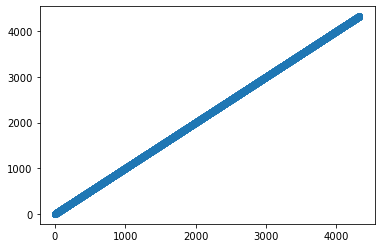

In [10]:
plt.scatter(Ceres.times/3.154e+7/1e6,Ceres.times/3.154e+7/1e6)

In [11]:
j=45
i=45
print(Ceres.grid[j,i].AqComp)
print("")
print(Ceres.grid[j,i].IceComp)
print("")
print(Ceres.grid[j,i].RockComp)
print("")
print(Ceres.grid[j,i].Temp)
print("")
print(Ceres.grid[j,i].Mass)

{'H': 955432286714928.8, 'C': 36105379154.03811, 'Mg': 0.0, 'Al': 0.0, 'Si': 0.0, 'S': 0.0, 'Ca': 0.0, 'Fe': 0.0, 'O': 0.00775399188285388, 'Na': 0.0, 'N': 4.63505223378811e+17, 'H2O': 3.640885942589625e+19}

{'H2O': 0}

{'H': 0, 'C': 0, 'Mg': 0, 'Al': 0, 'Si': 0, 'S': 0, 'Ca': 0, 'Fe': 0, 'O': 0, 'Na': 0, 'N': 0, 'IOM': 0}

273.15

3.6873320117667156e+19


In [12]:
for i in range(0,nr):
    for j in range(0,maxnt):
        Ceres.grid[j,i].Temp2=Ceres.grid[j,i].Temp
        if "H2O" in Ceres.grid[j,i].AqComp and Ceres.grid[j,i].AqComp["H2O"]>2e19:
            Ceres.grid[j,i].Temp2=278

(0.3978849266145215, 3.636160644457143)

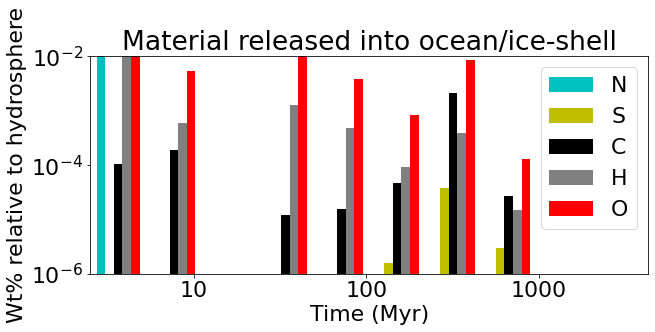

In [59]:
def plot_binned_bar_chart(X, Y, m,lab,col):
    n = len(X)
    # Check if m is valid
    if m >= n:
        raise ValueError("Number of bars (m) must be less than the length of the data (n)")
    # Calculate the bin size
    bin_size = n // m
    # Calculate the bin edges
    bin_edges = np.arange(0, n + bin_size, bin_size)
    # Create an array to store the binned values
    binned_values = np.zeros(m)
    bin_locs = np.zeros(m)
    # Bin the data
    Xlin=np.linspace(X[0],X[-1],len(X))
    for i in range(m):
        start_idx = bin_edges[i]
        end_idx = bin_edges[i + 1] if i < m - 1 else n
        bin_locs[i] = np.mean(Xlin[start_idx:end_idx])
        Xi1=np.argmin(np.abs(X-Xlin[start_idx]))
        Xi2=np.argmin(np.abs(X-Xlin[end_idx-1]))
        binned_values[i] = np.mean(Y[Xi1:Xi2])
    # Plot the binned bar chart
    plt.bar(bin_locs, binned_values, align='center',width=0.05,label=lab,color=col)
    plt.xlabel('Time (Myr)')
    plt.ylabel('Wt% relative to hydrosphere')
    plt.title('Material released into ocean/ice-shell')
    plt.yscale("log")
    #plt.show()

axes=plt.figure(figsize=(10,4))
for j in ["N","S","C","H","O"]:
    Car=np.zeros(maxnt)
    hydroM=np.zeros(maxnt)
    for i in range(0,maxnt):
        if j in Ceres.extracts[i]:
            Car[i]+=Ceres.extracts[i][j]
        for k in range(0,nr):
            hydroM[i]+=(Ceres.grid[i,k].AqMass+Ceres.grid[i,k].IceMass)
            if j in Ceres.grid[i,k].OrgComp:
                Car[i]+=Ceres.grid[i,k].OrgComp[j]
    #plt.plot(Ceres.times/3.154e+7/1e6,Car,label=j)
    logTimes = np.log10(Ceres.times/3.154e+7/1e6)
    offset=0
    col='k'
    mult=2
    if j=="H":
        offset=0.05
        col='grey'
        mult=2
    if j=="O":
        offset=0.1
        col='r'
    if j=="S":
        offset=-0.05
        col="y"
        mult=10
    if j=="N":
        offset=-0.1
        col="c"
    logTimes+=offset
    #plot_binned_bar_chart(logTimes, Car/Ceres.Mass/ICE_frac*100, 10,j,col)
    plot_binned_bar_chart(logTimes, mult*Car/hydroM*100, 10,j,col)

plt.legend()
plt.ylim([10**-6,10**-2])
plt.xticks([1, 2, 3], ['10', '100','1000'])
plt.xlim(np.log10([stime,etime]))
#plt.xscale('log')
#print(Ceres.Mass)

In [14]:
Ceres.grid[149,40].Temp

440.9322696471739

In [15]:
tS=14
Ntot=0
elList=["H","C","Mg","Al","Si","S","Ca","Fe","O","Na","N","H2O","IOM"]
elList=["Fe"]
for j in elList:
    el=j
    for i in range(0,51):
        if el in Ceres.grid[tS,i].AqComp:
            Ntot+=Ceres.grid[tS,i].AqComp[el]
        if el in Ceres.grid[tS,i].RockComp:
            Ntot+=Ceres.grid[tS,i].RockComp[el]
        if el in Ceres.grid[tS,i].IceComp:
            Ntot+=Ceres.grid[tS,i].IceComp[el]
print(Ntot)

1.0769232712839728e+20


(2.4996829422954976, 4326.7384642661455)

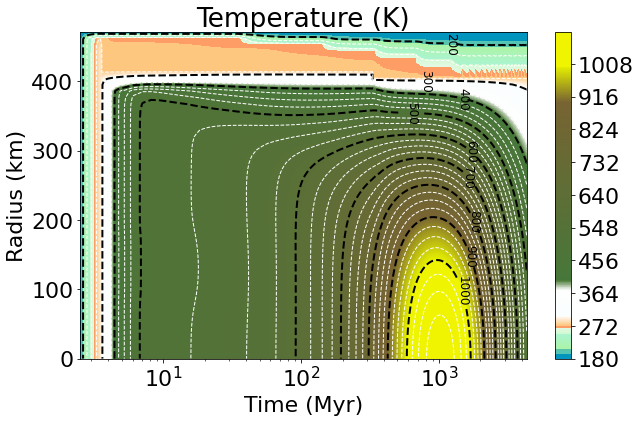

In [16]:
Ceres.plotTemp("Temp","Temperature (K)")
plt.xscale("log")
plt.xlim([stime,etime])
#plt.set_cmap('jet')

In [17]:
tInd = 23
rInd = 0
print(Ceres.grid[tInd,rInd].getIceMass())
print(Ceres.grid[tInd,rInd].getRockMass())
print(Ceres.grid[tInd,rInd].getWaterMass())
print(Ceres.grid[tInd,rInd].Mass)
print(Ceres.grid[tInd,rInd].Celltype)
#print(Ceres.grid[tInd,rInd].RockComp)
#print(Ceres.grid[tInd,rInd].IceComp)

0
5936776705468880.0
0
5936776705468880.0
3


In [18]:
for i in Ceres.grid[99,44].AqSpec:
    print(i+": "+str(Ceres.grid[99,44].AqSpec[i])+" M")

H+: 1.0552e-10 M
Cl-: 0.00019141 M
OH-: 1.751e-05 M
H2(aq): 1.3457e-10 M
SiO2(aq): 5.4758e-07 M
K+: 1.0001e-19 M
Ni++: 1.0001e-19 M
Na+: 1e-19 M
Ca++: 7.2955e-20 M
Fe++: 3.9549e-09 M
Mg++: 4.2096e-05 M
Mn++: 9.9992e-20 M
CO2(aq): 2.8378e-07 M
SO4--: 1.1697e-08 M
Al+++: nan M
NH4+: 0.0022764 M
N2(aq): 0.53789 M
HCO3-: 0.001161 M
MgCl+: 5.3636e-09 M
AlOH++: 2.5894e-17 M
HSO4-: 3.6581e-17 M
FeCl+: 3.9767e-13 M
HSiO3-: 4.2481e-07 M
NH3(aq): 0.0016597 M
Al(OH)2+: 7.7126e-14 M
HAlO2(aq): 1.7445e-10 M
CO3--: 0.00049525 M
MgHCO3+: 4.508e-07 M
FeCl2(aq): 2.9557e-19 M
Fe+++: nan M
AlO2-: 1.6777e-07 M
MgCO3(aq): 8.8249e-06 M
H2S(aq): 5.1363e-11 M
Formate: 5.7046e-10 M
Formic_acid(aq): 3.0411e-16 M
HSO3-: nan M
HS-: 2.6181e-08 M
Mg(For)+: 8.4063e-13 M
Fe(For)+: 1.9005e-16 M
Methane(aq): 6.8852e-09 M
SO3--: 6.8476e-19 M
Urea(aq): 4.7406e-12 M
Acetate: 1.4558e-14 M
S2O3--: nan M
S2--: 9.356e-20 M
Oxalate: 1.3537e-17 M
CO(aq): 3.1334e-19 M
Acetamide(aq): 5.0594e-17 M
NH4CH3COO(aq): 4.5289e-17 M
MgCH3

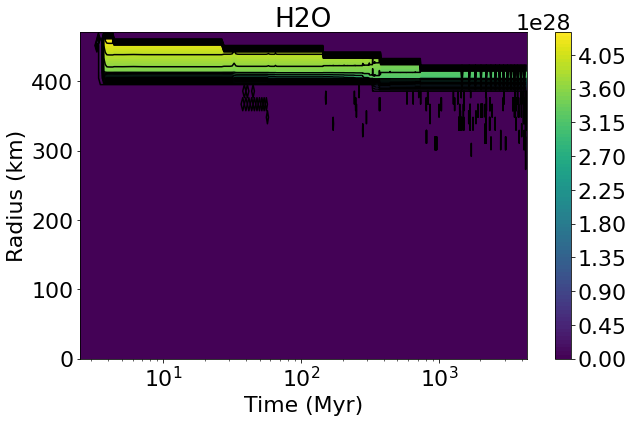

In [19]:
Ceres.plotDictAttribute("AqComp","H2O","H2O",10**9)
plt.xscale("log")

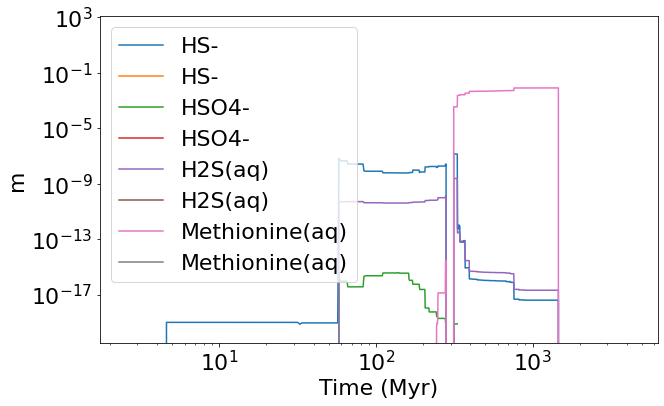

In [20]:
Ceres.multiplotDictAttributeLine("AqSpec",["HS-","HSO4-","H2S(aq)","Methionine(aq)"],"m",44,1)
#plt.ylim([10**-2,100])
plt.yscale('log')
plt.xscale('log')

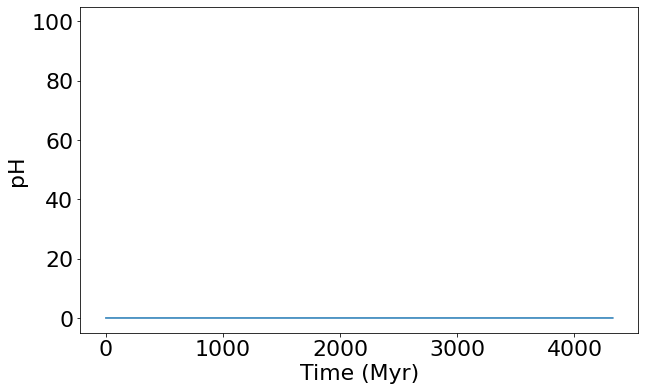

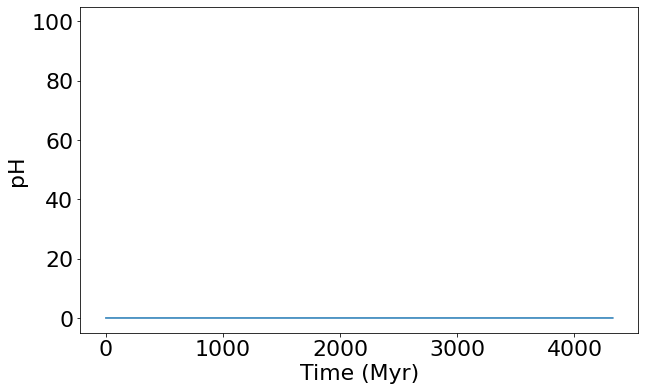

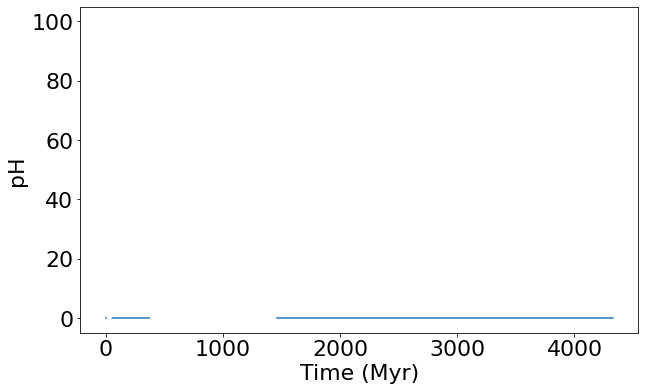

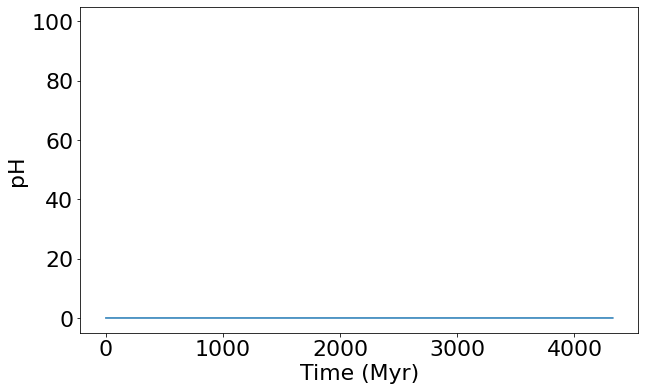

In [34]:
f,H2S=Ceres.plotDictAttributeLine("AqSpec","H2S(aq)","pH",44,1)
f,HS=Ceres.plotDictAttributeLine("AqSpec","HS-","pH",44,1)
f,SO4=Ceres.plotDictAttributeLine("AqSpec","SO4--","pH",44,1)
f,Meth=Ceres.plotDictAttributeLine("AqSpec","Methionine(aq)","pH",44,1)

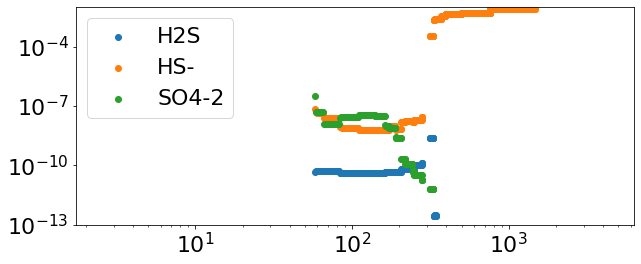

In [61]:
axes=plt.figure(figsize=(10,4))
plt.scatter(Ceres.times/3.154e+7/1e6,H2S,label="H2S")
plt.scatter(Ceres.times/3.154e+7/1e6,HS+Meth,label="HS-")
plt.scatter(Ceres.times/3.154e+7/1e6,SO4,label="SO4-2")
#plt.scatter(Ceres.times/3.154e+7/1e6,Meth,label="Methionine")
plt.legend(loc="upper left")
plt.ylim([10**-13,10**-2])
plt.yscale('log')
plt.xscale('log')

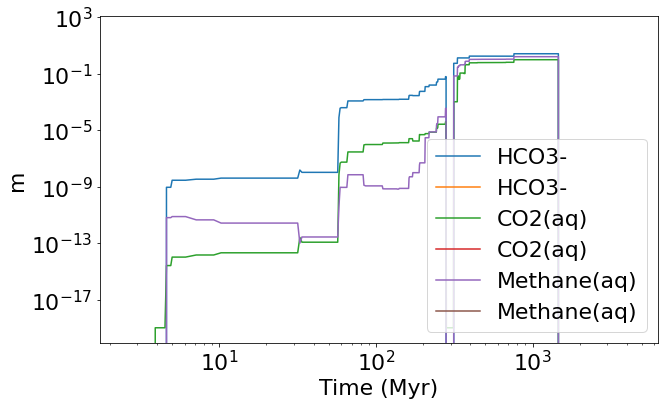

In [21]:
Ceres.multiplotDictAttributeLine("AqSpec",["HCO3-","CO2(aq)","Methane(aq)"],"m",44,1)
#plt.ylim([10**-2,100])
plt.yscale('log')
plt.xscale('log')

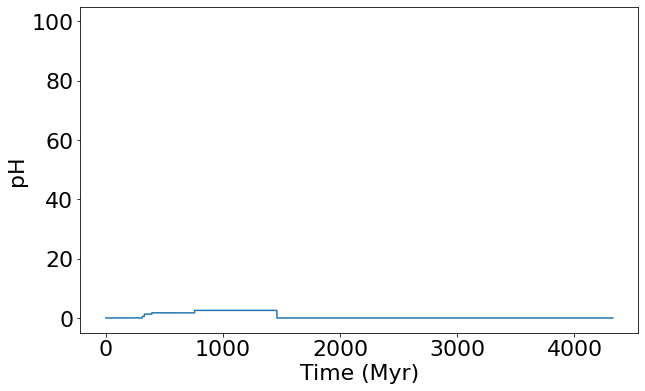

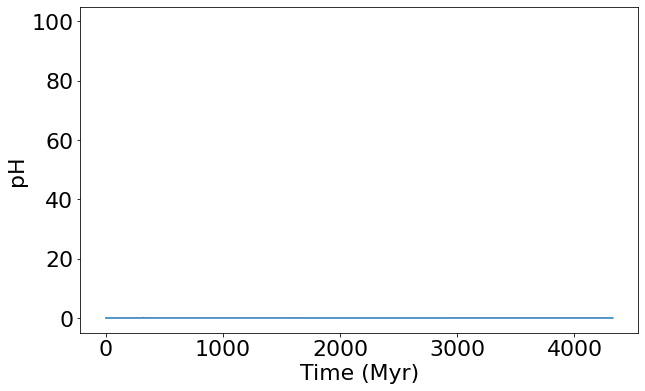

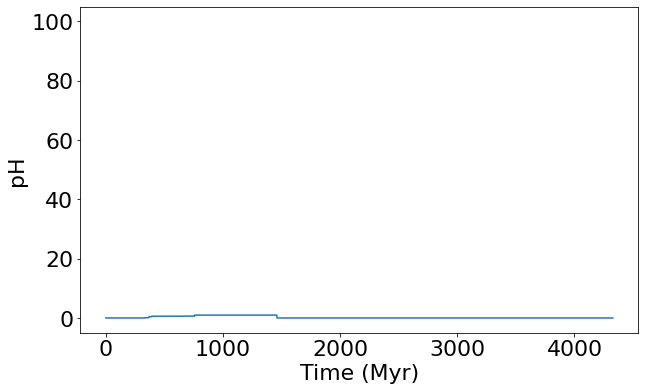

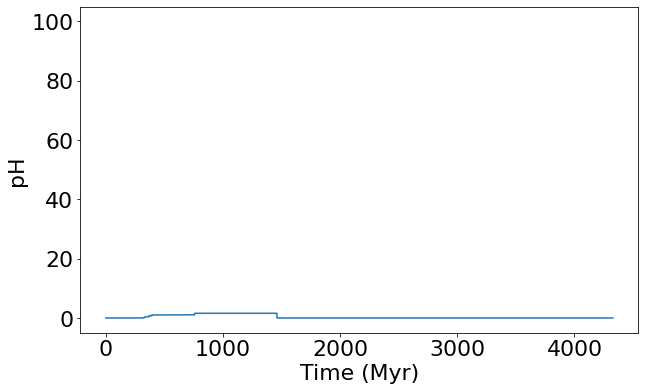

In [22]:
f,HCO3=Ceres.plotDictAttributeLine("AqSpec","HCO3-","pH",44,1)
f,CO3=Ceres.plotDictAttributeLine("AqSpec","CO3--","pH",44,1)
f,CO2=Ceres.plotDictAttributeLine("AqSpec","CO2(aq)","pH",44,1)
f,CH4=Ceres.plotDictAttributeLine("AqSpec","Methane(aq)","pH",44,1)

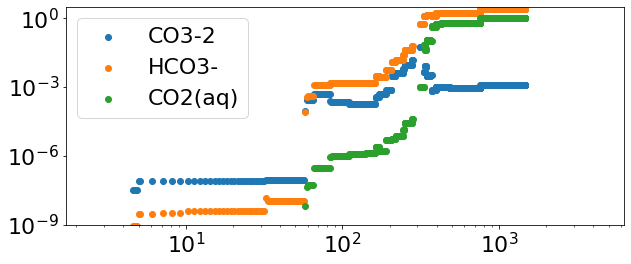

In [58]:
axes=plt.figure(figsize=(10,4))
plt.scatter(Ceres.times/3.154e+7/1e6,CO3,label="CO3-2")
plt.scatter(Ceres.times/3.154e+7/1e6,HCO3,label="HCO3-")
plt.scatter(Ceres.times/3.154e+7/1e6,CO2,label="CO2(aq)")
#plt.scatter(Ceres.times/3.154e+7/1e6,CH4,label="CH4(aq)")
plt.legend()#location="NW")
plt.ylim([10**-9,3])
plt.yscale('log')
plt.xscale('log')

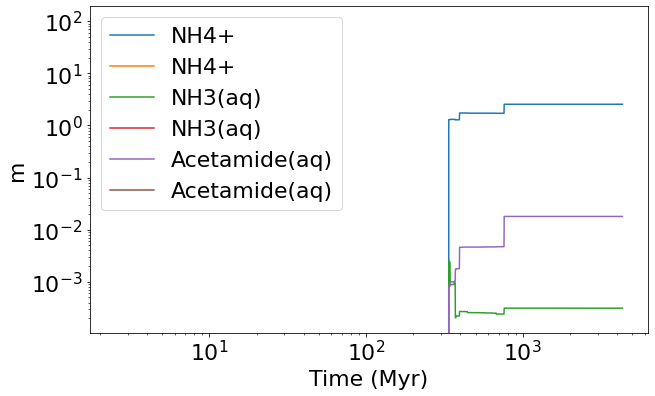

In [24]:
Ceres.multiplotDictAttributeLine("AqSpec",["NH4+","NH3(aq)","Acetamide(aq)"],"m",43,1)
#plt.ylim([10**-2,100])
plt.yscale('log')
plt.xscale('log')

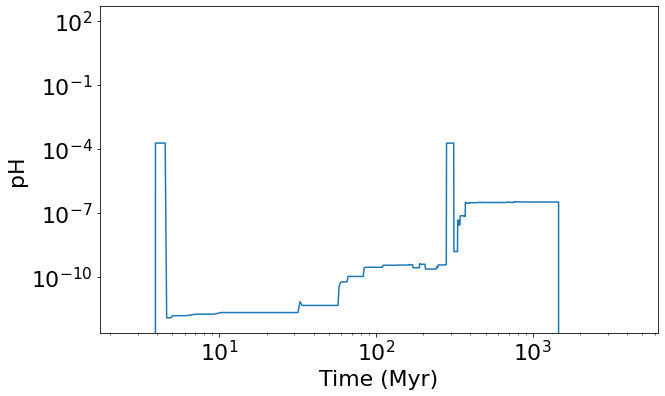

In [25]:
f,H=Ceres.plotDictAttributeLine("AqSpec","H+","pH",44,1)
plt.yscale('log')
plt.xscale('log')
#plt.plot(Ceres.times/3.154e+7/1e6,-np.log(H))
#plt.ylim([2,12])

/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_13800/4284777315.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(Ceres.times/3.154e+7/1e6,-np.log10(H),color="k")


Text(0.5, 0, 'Time (Myr)')

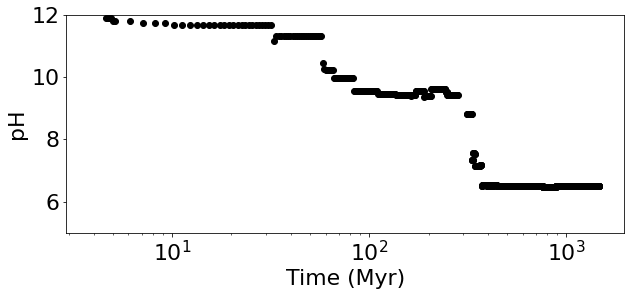

In [26]:
axes=plt.figure(figsize=(10,4))
plt.scatter(Ceres.times/3.154e+7/1e6,-np.log10(H),color="k")
plt.ylim([5,12])
#plt.yscale('log')
plt.xscale('log')
plt.ylabel("pH")
plt.xlabel("Time (Myr)")

In [27]:
print(Ceres.grid[1,0].latentHeat)
print(Ceres.grid[1,0].Mass)
print(Ceres.grid[1,0].Temp)
print((Ceres.times[2]-Ceres.times[1])*10**-13)

0
5936776705468877.0
196.55774758207667
0.31558


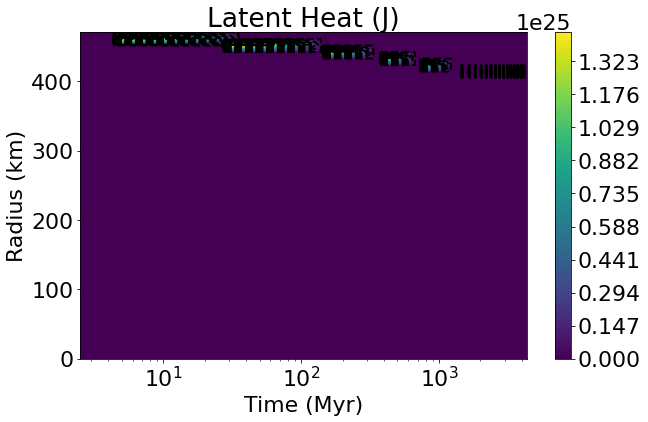

In [28]:
Ceres.plotAttribute("latentFreeze","Latent Heat (J)")
plt.xscale("log")

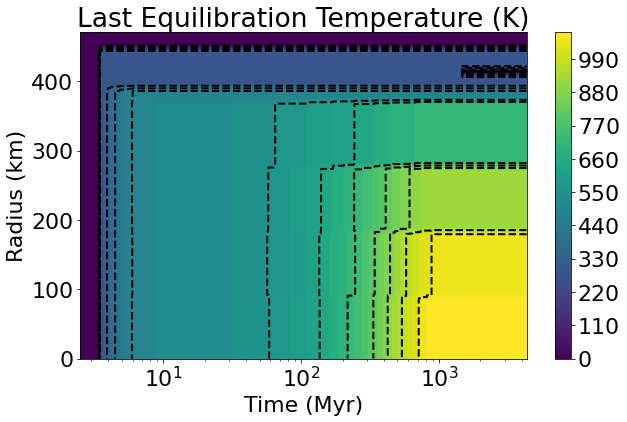

In [29]:
Ceres.plotAttribute("lastEquil","Last Equilibration Temperature (K)")
plt.xscale("log")

ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
n

/Users/samuelcourville/Documents/JPL/combinedModel/WOW.py:1085: RuntimeWarning: invalid value encountered in double_scalars
  pP[i][j]=pP[i][j]/sumM[j]*(100-IOMp)


(2.4996829422954976, 4326.7384642661455)

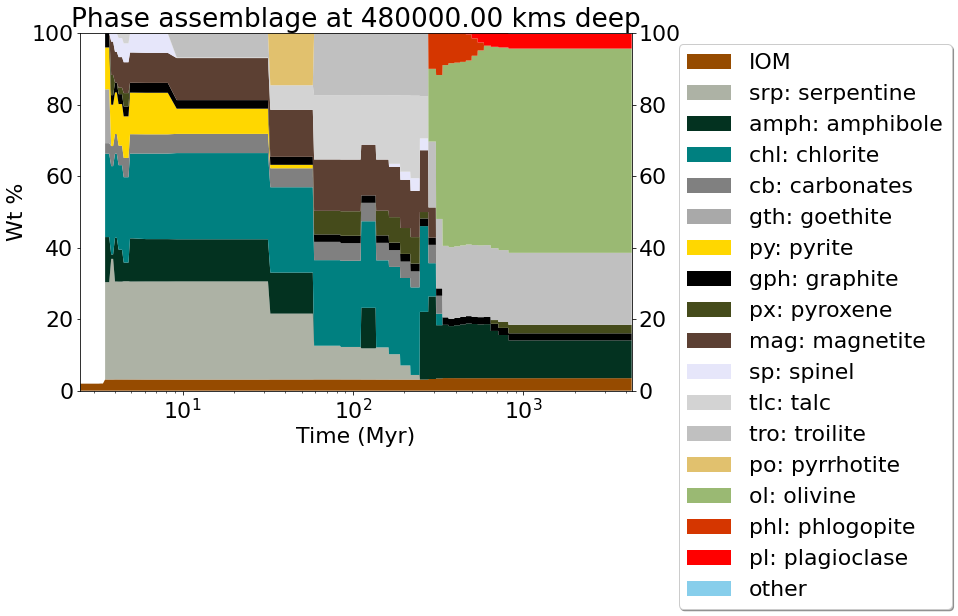

In [30]:
ax = Ceres.plotPhaseAssemblage(0,[])
plt.xscale("log")
plt.xlim([stime,etime])
#plt.legend(bbox_to_anchor=(1.6, 1.0), loc='upper right',
#                   ncol=1, fancybox=True, shadow=True)

/Users/samuelcourville/Documents/JPL/combinedModel/WOW.py:942: RuntimeWarning: invalid value encountered in double_scalars
  pP[i][j] = pP[i][j] / sumM[j] * (100 - IOMp)


(2.4996829422954976, 4326.7384642661455)

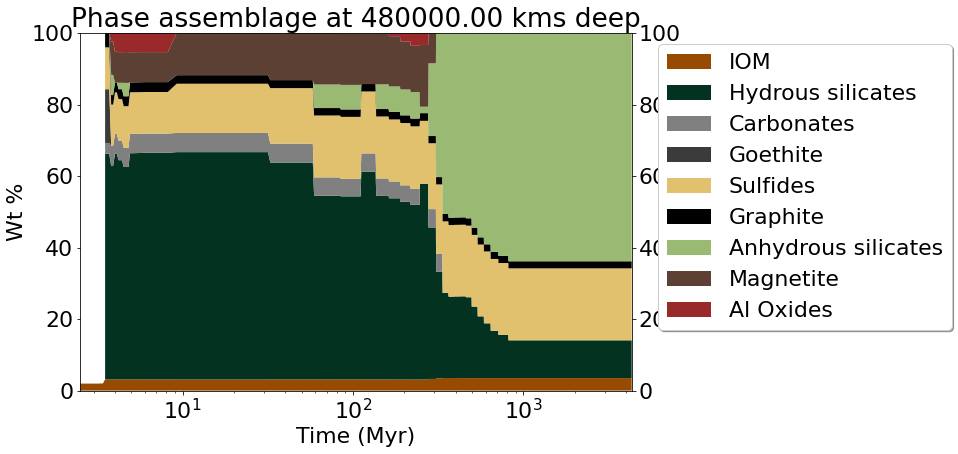

In [31]:
ax = Ceres.plotSimplePhases(0,["iron"])
plt.xscale("log")
plt.xlim([stime,etime])

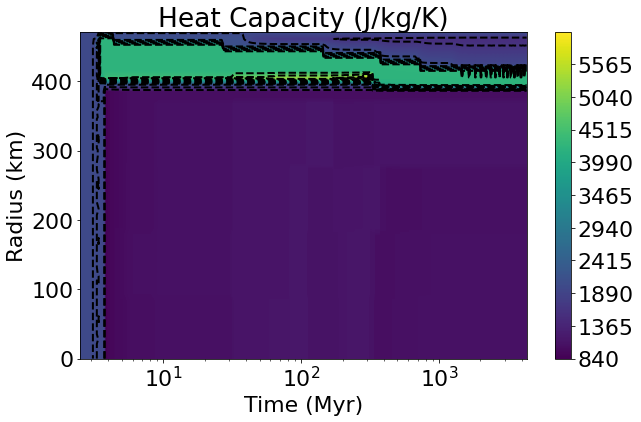

In [32]:
plt.rc('image', cmap='viridis')
Ceres.plotAttribute("Cp","Heat Capacity (J/kg/K)")
plt.xscale("log")

In [33]:
Ceres.grid[21,92].TCond

IndexError: index 92 is out of bounds for axis 1 with size 51

In [ ]:
Ceres.plotAttribute("TCond","k ()")
plt.xscale("log")

In [ ]:
Ceres.plotAttribute("Dens","Density (kg/m3)")

In [ ]:
Ceres.plotAttribute("Press","Pressure (Pa)")

In [ ]:
Ceres.plotAttribute("Mass","Mass (kg)")

In [ ]:
Ceres.plotAttribute("Bot","Bottom (m)")

In [ ]:
Ceres.plotAttribute("Top","Top (m)")

In [ ]:
ax = Ceres.plotPhaseAssemblage(0)
plt.xscale("log")

In [ ]:
print(Ceres.grid[99,0].RockPhaseDat[6])

In [ ]:
#for i in range(0,1500):
#    if not Ceres.grid[i,1].RockPhaseDat:
#        print(Ceres.grid[i,0].RockPhaseDat)
#        print(i)
        
print(Ceres.grid[99,0].RockPhases)
print(Ceres.grid[99,0].RockPhaseDat[1])

In [ ]:
Ceres.plotDictAttributeMassScaled("IceComp","H2O","Mass fraction Ice",0,1)
plt.xscale("log")

In [ ]:
Ceres.plotDictAttributeMassScaled("AqComp","N","Mass fraction C",0,1)
plt.xscale("log")

In [ ]:
Ceres.plotDictAttributeMassScaled("RockComp","IOM","Mass IOM",0,0.04)

In [ ]:
testPlot = Ceres.plotDictAttributeLine("RockComp","IOM","IOM",0)

In [ ]:
testPlot = Ceres.plotDictAttribute("AqComp","H2O","H2O")
#plt.yscale('log')
plt.xscale('log')

In [ ]:
testPlot = Ceres.plotDictAttributeLine("AqComp","CO2","H2O",41)
#plt.ylim([0.6,0.672])
#plt.yscale('log')
#plt.xscale('log')

In [ ]:
Ceres.grid[3,45].AqComp

In [ ]:
#from matplotlib.colors import LinearSegmentedColormap

# Define the colors and ranges
colors = ['black', 'grey', '#0047AB', '#C19A6B', '#b9e8ea']

# Create a colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)
plt.colorbar(plt.cm.ScalarMappable(cmap=custom_cmap), orientation='horizontal', ticks=bounds)

plt.rc('image', cmap='gray')
plt.imshow([[i] for i in range(100)])
plt.colorbar()

In [ ]:
plt.rc('image', cmap=custom_cmap)
Ceres.plotAttribute("Celltype","Cell Type")
plt.xscale("log")

In [ ]:
Ceres.grid[33,0].RockPhases

In [ ]:
Ceres.grid[33,0].RockPhaseDat[3]

In [ ]:
Ceres.plotDictAttribute("RIComp","K40","K40 ppb",10**9)
plt.xscale("log")

In [ ]:
Ceres.plotDictAttribute("RIComp","Al26","Al26 ppb",10**9)
plt.xscale("log")

In [ ]:
testPlot = Ceres.plotDictAttributeLine("RIComp","K40","K40 ppb",0,10**9)
#plt.xlim([2,12])
plt.yscale('log')
plt.xscale('log')

In [ ]:
Ceres.plotAttributeLine("MaxOrgTemp","max temp(K)",2)
#plt.xlim([2,12])

In [ ]:
ts = Ceres.times
nt=len(ts)
oceanT=np.zeros(nt)
oceanpH2=np.zeros(nt)
for i in range(0,nt):
    oceanT[i]=Ceres.grid[i,43].Temp
    if "H2(aq)" in Ceres.grid[i,43].AqSpec:
        oceanpH2[i]=-np.log10(Ceres.grid[i,43].AqSpec["H2(aq)"])
    else:
        oceanpH2[i]=np.nan

plt.set_cmap('pink')
plt.figure(figsize=(8,4))
cts=ts/np.max(ts)    
plt.scatter(oceanT,oceanpH2,50,c=cts)
#plt.xlim([200,300])
#plt.ylim([8,10])
#plt.plot(ts,oceanT)

plt.xlabel('ocean temp (k)')
plt.ylabel('ocean pH2')
plt.colorbar()

In [ ]:

plt.figure(figsize=(8,4)) 
plt.plot(ts[0:-1]*10**-7*10**-6/3.154,np.diff(oceanpH2))
plt.xlim(0,2000)

In [ ]:
H=1.0
C=12.01
N=14.01
O=16
Na=22.99
Mg=24.31
Al=26.98
Si=28.09
S=32.07
Cl=35.45
K=39.10
Ca=40.08
Mn=54.94
Fe=55.85
Ni=58.69

In [ ]:
init_RockComp

In [ ]:
#from scipy.special import erf
#
#t=np.linspace(273,1200,100)
#prevOrgT=573
#factSam=0.47
#H2Orel=0.004/factSam*(erf((t-620)/210)+1)
#CO2rel=0.0102/factSam*(erf((t-680)/240)+1)
#CH4rel = 0.0015/factSam*(erf((t-860)/110)+1)#-0.0015/factSam*(erf((prevOrgT-860)/110)+1)
#Cfrac = (12.0/44.0*CO2rel+12.0/16.0*CH4rel)
#Ofrac = (32.0/44.0*CO2rel+16.0/18.0*H2Orel)
#Hfrac = (2.0/18.0*H2Orel+4.0/16.0*CH4rel)
#Mtot=Cfrac+Ofrac+Hfrac
#plt.plot(t,CH4rel)
#plt.plot(t,Mtot)
#Mtot[2]-Mtot[1]